Pick out graphs size < 200

In [1]:
from node_attributes import classify_operator, match_constant

def node_features(G):
    """
    Extract features in each node:
    7 operator features + 2 operand features.
    """
    features = np.zeros((number_of_nodes(G), 7 + 2))
    for (i, (node, attributes)) in enumerate(G.nodes(data=True)):
        instructions = attributes['Ins']
        for (addr, inst) in instructions:
            if len(inst) == 0:
                break
            """
            Format of assembly code: "operator operand, operand, ..., operand"
            """
            operator_class = classify_operator(inst[0])
            features[i, operator_class] += 1
            if len(inst) == 1:
                continue
                
            for part in inst[1].split(','):
                comment_idx = part.find(';')
                operand = part if comment_idx == -1 else part[:comment_idx]
                numeric_cnts, string_cnts = match_constant(operand)
                features[i, -2] += numeric_cnts
                features[i, -1] += string_cnts
                
    return features

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import glob
import pickle as pkl
import numpy as np
import scipy as sp
import pandas as pd
from networkx import number_of_nodes, adjacency_matrix

class_dirnames = glob.glob('*')

small_graph_filenames = []
total = 0
MAX_GRAPH_SIZE = 200
output_dir = 'SmallACFGs/'
CFG_labels = ['Benign', 'Bagle', 'Bifrose']

"""Path name format: class/graph_id/pkl_name"""
for class_dirname in class_dirnames:
    if class_dirname not in CFG_labels:
        continue
        
    print("Processing %s CFGs" % class_dirname)
    data_dirnames = glob.glob(class_dirname + '/*')
    for data_dirname in data_dirnames:
        pkl_filenames = glob.glob(data_dirname + '/*')
        if len(pkl_filenames) == 0:
            print('[Warning] %s is empty' % data_dirname)
        else:
            # Assume only 1 file under data dir
            total += 1
            G = pkl.load(open(pkl_filenames[0], 'rb'))
            graph_id = pkl_filenames[0].split('/')[1]
            label = class_dirname
            
            if number_of_nodes(G) < MAX_GRAPH_SIZE:
                small_graph_filenames.append(pkl_filenames[0])
                features = node_features(G)
                np.savetxt(output_dir + graph_id + '.features.txt', features, fmt="%d")
                np.savetxt(output_dir + graph_id + '.label.txt', np.array([label]), fmt="%s")
                np.savetxt(output_dir + graph_id + '.adjacent.txt', adjacency_matrix(G).todense(), fmt="%d")
                sp.sparse.save_npz(output_dir + graph_id + '.adjacent', adjacency_matrix(G))


np.savetxt(output_dir + 'small_graph_filenames.csv', small_graph_filenames, fmt="%s")
small_cnt = len(small_graph_filenames)
print("%d / %d = %.2f" % (small_cnt, total, small_cnt / total))
print("10 random files processed")
print([small_graph_filenames[x] for x in np.random.randint(0, small_cnt, size=10)])

Processing Bagle CFGs
Processing Bifrose CFGs
[Warning] Bifrose/68577f95d878fb0d3cb1ccb311bcd375 is empty
Processing Benign CFGs
[Warning] Benign/ef11db385af16b633efbd524907baa58 is empty
1070 / 1689 = 0.63
10 random files processed
['Bifrose/33693d34f1afcfb4eb5509496b7f5207/Trojan.Win32.Midgare.hgi.gpickle', 'Bagle/4fb426de872ee9b20c3312fae3adf018/Email-Worm.Win32.Bagle.cs.gpickle', 'Bifrose/570d2f8c7fbb56702a5645092a8d84c5/Backdoor.Win32.Bifrose.aaxv.gpickle', 'Bifrose/49342d8c6891b1f15446b5a6de9bc602/Backdoor.Win32.Bifrose.tyt.gpickle', 'Bifrose/367d4ba61ea0245147e23ebd270f5876/Backdoor.Win32.Bifrose.amil.gpickle', 'Bifrose/1c91ca899855227113c24cd04315da5a/ar4up-4a0a67278d.gpickle', 'Bifrose/4d780199a04962859b42d072f0604747/CC22AB97.EXE.gpickle', 'Bagle/2466231afa5cd01eb38131419d1a810e/Worm.Bagle.AC.cpl.gpickle', 'Bifrose/55d2d0193e6ace4488d664933d67daa6/Trojan.Win32.Midgare.sry.gpickle', 'Bifrose/5a488694a72518619864a300e57db722/41473667.EXE.gpickle']


Counter({'Bifrose': 917, 'Bagle': 136, 'Benign': 17})


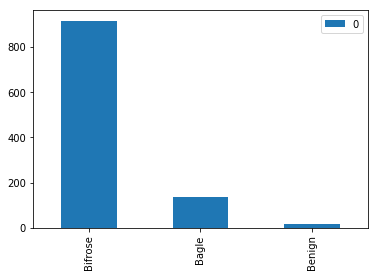

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

data = pd.read_csv('SmallACFGs/small_graph_filenames.csv',
                   delimiter='/', names=['label', 'graph_id', 'filename'])
label_cnts = Counter(data['label'])
print(label_cnts)
df = pd.DataFrame.from_dict(label_cnts, orient='index')
df.plot(kind='bar')